# A preliminary pipeline to collect features

In [1]:
import jusipy
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# Load datasets
LM        = jusipy.deals.LandMatrix()
A_country = jusipy.country_features.All()
A_latlong = jusipy.latlong_features.All()
GLCF_8km  = A_latlong.datasets[2]         # extract from A_latlong, just to not load this one twice...

Loading GLCF(8km)                                                                                                     reas)                                                                                                      

In [3]:
# Load GIS tools
GC = jusipy.GIS.GoogleCode(cache=jusipy.utils.FireDict(sub='googlecode'))
CC = jusipy.GIS.CountryCode()
CLL = jusipy.GIS.CountryLatLong()

## Select the points, and get the relevant data

### Positive points from LandMatrix

In [21]:
positive_points = LM.M[['lat', 'long', 'target_country_iso3', 'negotiation_year']]
positive_points = positive_points.rename(columns={'target_country_iso3' : 'country',
                                                  'negotiation_year' : 'year'})
positive_points['positive'] = 1
positive_points['random']   = 0
positive_points['year'] = positive_points.year.apply(lambda x: 'newest' if pd.isna(x) else x)

### Random points selected from around the earth

In [6]:
random_points = pd.DataFrame(jusipy.GIS.sample.random_latlong(land=True, glcf=GLCF_8km, size=11000),
                             columns=['lat', 'long'])
random_points.to_pickle('data/random_points.pkl')
random_points = pd.read_pickle('data/random_points.pkl')
random_points['country'] = CLL.get(zip(random_points.lat, random_points.long))

random_points['year'] = ['newest'] * len(random_points.lat)
random_points['positive'] = 0
random_points['random']   = 1

random_points = random_points[~pd.isna(random_points.country)]

### Combine the two stacks of data

In [4]:
#all_points = pd.concat([positive_points, random_points])
#all_points.to_pickle('data/all_points.pkl')
#all_points
all_points = pd.read_pickle('data/all_points.pkl')

## Visualize the selected points

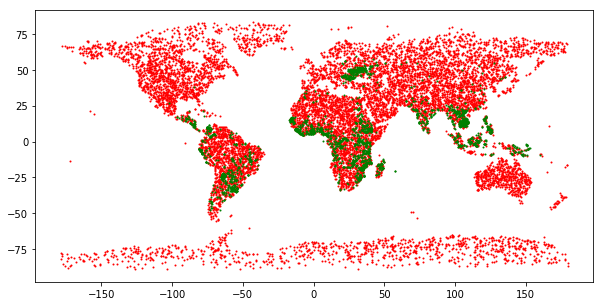

In [9]:
plt.figure(figsize=(10,5))
cb = plt.scatter(all_points.long[all_points.random == 1], all_points.lat[all_points.random ==1], c='r', s=1, zorder=1)

plt.scatter(all_points.long[all_points.random == 0], all_points.lat[all_points.random ==0], c='g', s=1, zorder=2)


## Collect features for each point

In [1]:
import jusipy
import pandas as pd
all_points = pd.read_pickle('data/all_points.pkl')
ne = jusipy.latlong_features.NaturalEarth()
#country_features = jusipy.country_features.get(all_points, A_country)
latlong_features = jusipy.latlong_features.get(all_points, ne)
#all_features = country_features.join(latlong_features)

Loading NaturalEarth(/Users/thiesgehrmann/repos/JuSiPy_Asser/jusipy/latlong_features/data/natural_earth/ne_10m_urban_areas)                                                                                                    

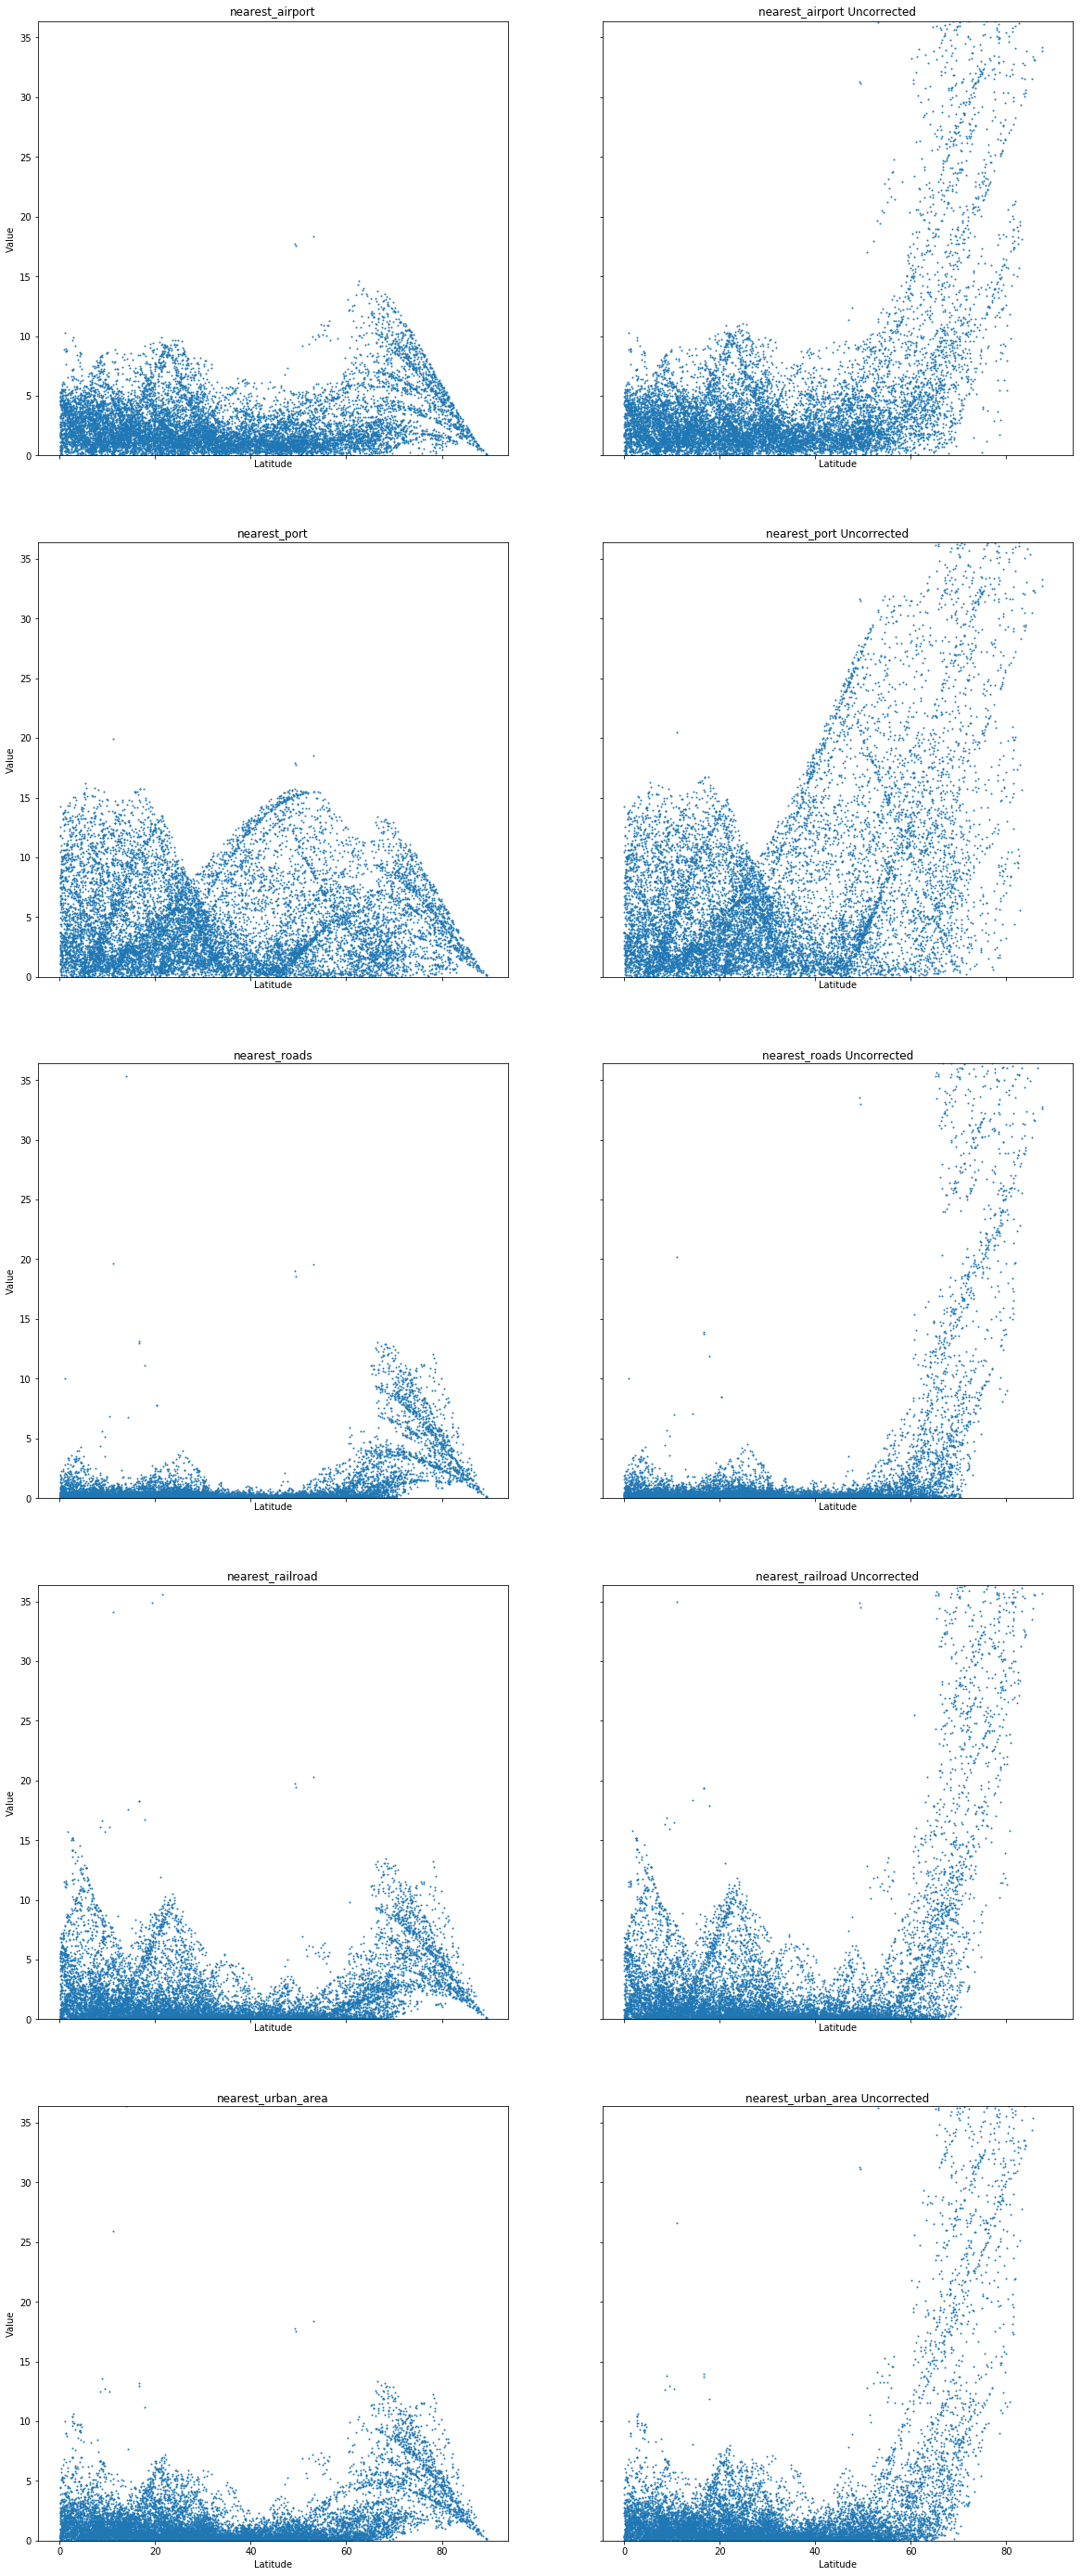

In [4]:
import numpy as np
import matplotlib.pylab as plt
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(20,50), sharex=True, sharey=True)

for i, col in enumerate([ c for c in latlong_features.columns if 'nearest' in c]):
    axes[i,0].scatter(np.abs(all_points.lat), latlong_features[col], s=1)
    axes[i,0].set_ylim([0, max(latlong_features[col])])
    axes[i,0].set_title(col)
    axes[i,0].set_ylabel('Value')
    axes[i,0].set_xlabel('Latitude')
    corr = [ ((np.cos(np.pi*(lat/90))+1)/2)**(1/1.5) for lat in all_points.lat]
    axes[i,1].scatter(np.abs(all_points.lat), latlong_features[col] / corr, s=1)
    axes[i,1].set_ylim([0, max(latlong_features[col])])
    axes[i,1].set_title(col + ' Uncorrected')
    axes[i,1].set_xlabel('Latitude')
    

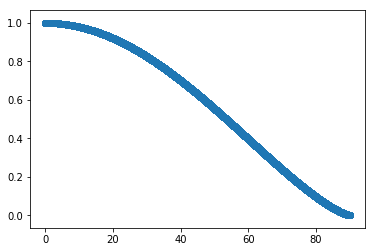

In [14]:
r = np.arange(0, 90, 1/1000)
plt.scatter(r, ((np.cos(np.pi*(r/90))+1)/2)**(1/1.5))

## Store the output

In [ ]:
all_points.to_pickle('data/all_labels.pkl')
all_features.to_pickle('data/all_features.pkl')

In [9]:
len(GC._cache._cache.keys())

5010

In [26]:
latlong_features = latlong_features.drop(columns=['coding_error_do_not_use_feature'])

In [110]:
neg = jusipy.deals.Negative(all_points, latlong_features, autorun=False)

In [111]:
neg.run(bandwidth=20)

Performing PCA
Performing TSNE
Performing Clustering
Selecting negatives


array([0, 0, 0, ..., 0, 1, 0])

No handles with labels found to put in legend.


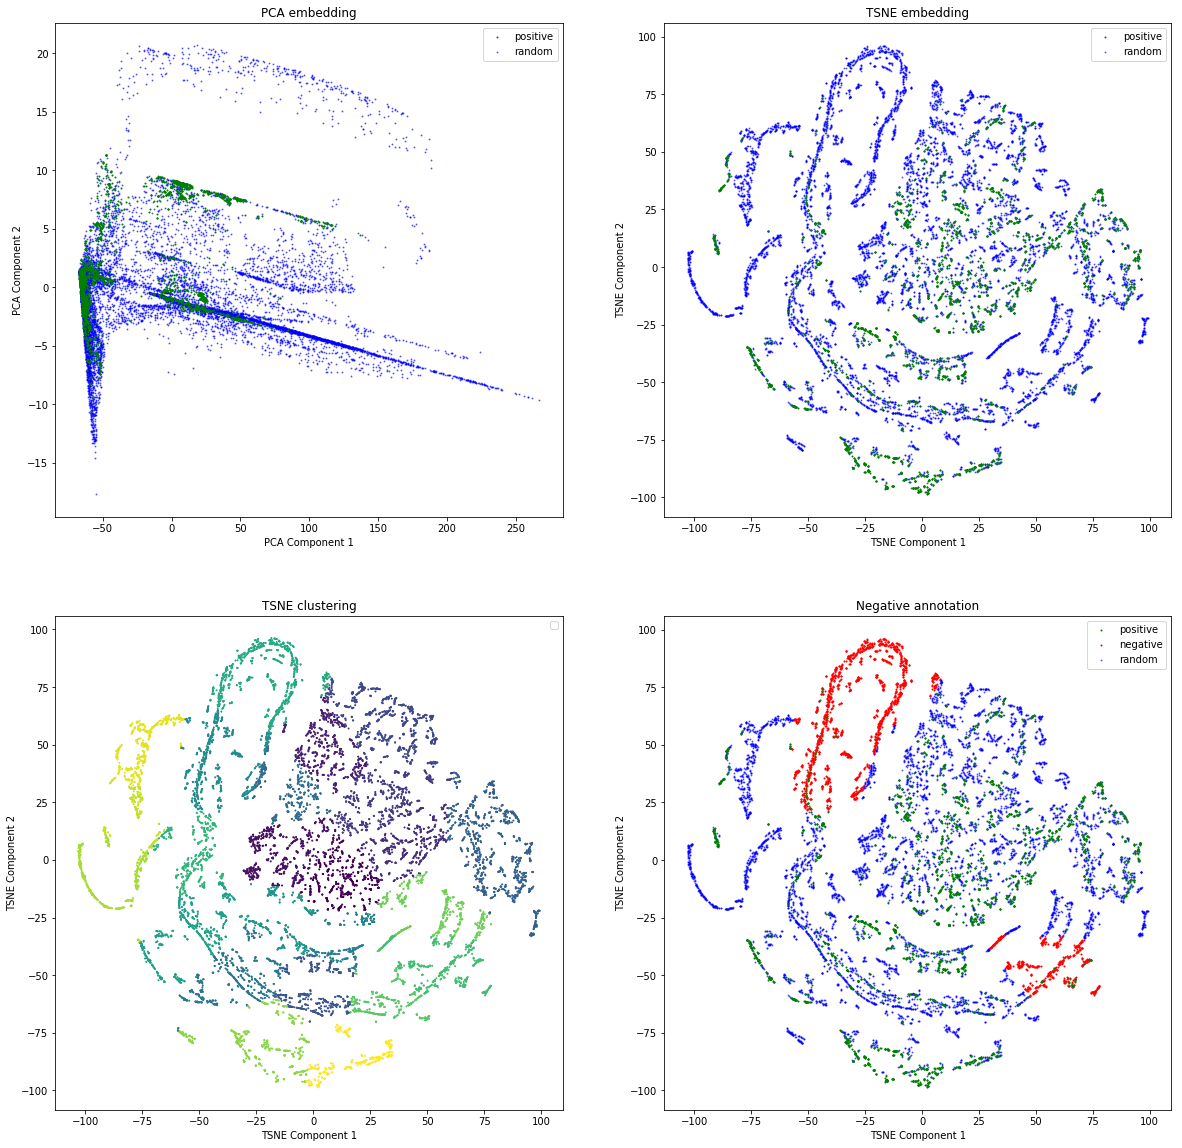

In [112]:
fig, axes = neg.plot()

In [126]:
{ k : v for (k,v) in A_country.description.items() if 'gdp' in v.lower() }

{'WB_SE__WB_NY_GDP_MKTP_KD_ZG': 'GDP growth (annual %)',
 'WB_SE__WB_NY_GDP_MKTP_PP_KD': 'GDP, PPP (constant 2011 international $)',
 'WB_ARD__NV_AGR_TOTL_ZS': 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'WB_SPL__SL_GDP_PCAP_EM_KD': 'GDP per person employed (constant 2011 PPP $)'}

In [124]:
A_country.features[['WB_SE__WB_NY_GDP_MKTP_KD_ZG', 'WB_SE__WB_NY_GDP_MKTP_PP_KD', 'WB_SPL__SL_GDP_PCAP_EM_KD']]

,WB_SE__WB_NY_GDP_MKTP_KD_ZG,WB_SE__WB_NY_GDP_MKTP_PP_KD,WB_SPL__SL_GDP_PCAP_EM_KD
country_iso3,,,
ABW,-5.653500,NaN,NaN
AFG,2.366710,NaN,6205.870117
AGO,-0.665353,4.707070e+10,15391.047852
ALA,NaN,NaN,NaN
ALB,3.369990,1.488070e+10,29206.273438
AND,1.232240,NaN,NaN
ARB,NaN,NaN,51734.499720
ARE,3.036460,2.631149e+11,99835.296875
ARG,-2.245340,5.130721e+11,45778.597656


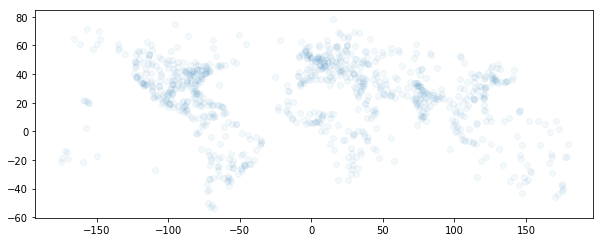

In [43]:
A_latlong.datasets[0]._loaded['airport']._DF.plot(figsize=(10,5), alpha=0.05)

In [6]:
latlong_features

,nearest_airport,nearest_port,nearest_roads,nearest_railroad,nearest_urban_area
index,,,,,
0,2.528767,2.874764,0.151229,1.392753,0.870040
1,0.854112,0.848171,0.009286,0.007576,0.518308
2,2.361454,2.395283,0.105342,1.829972,0.981527
3,1.462271,1.386547,0.008131,0.811306,1.342415
4,1.952968,1.962975,0.057229,0.988378,0.905570
5,0.990936,0.953782,0.044187,0.656155,0.888726
6,1.104298,1.073723,0.000675,0.682891,1.008498
7,0.752115,2.773223,0.090100,0.691103,0.668910
8,1.462271,1.386547,0.008131,0.811306,1.342415


Text(0.5, 1.0, 'np.log(distance to nearest airport)')

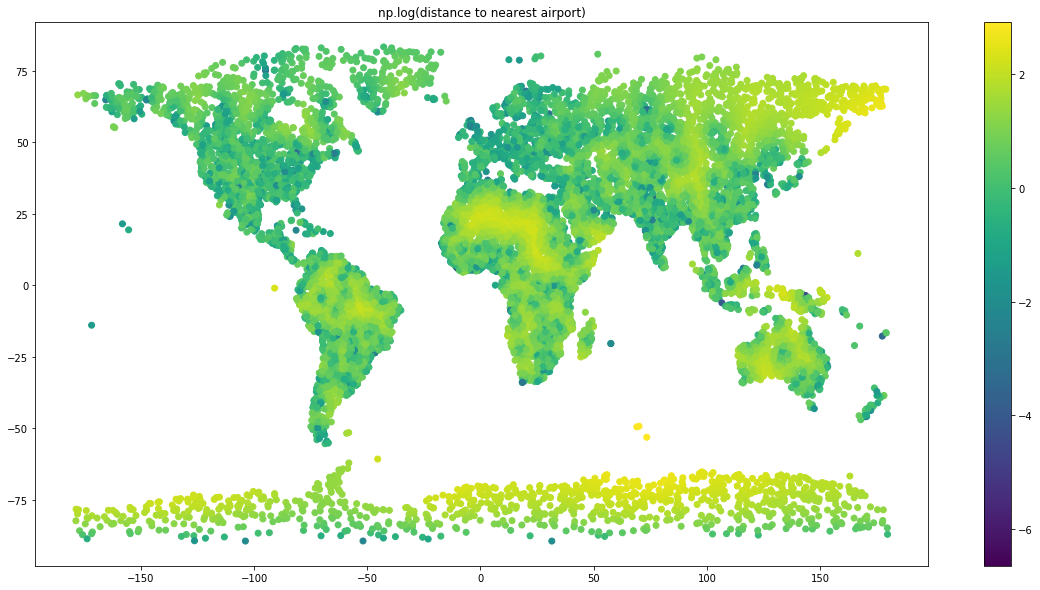

In [23]:
plt.figure(figsize=(20,10))
plt.scatter(all_points.long, all_points.lat, c=np.log(latlong_features.nearest_airport))
plt.colorbar()
plt.title('np.log(distance to nearest airport)')